<a href="https://colab.research.google.com/github/sumedh151/fusion-transformer/blob/main/fusion_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
import rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tqdm
import gc

from sklearn.metrics import confusion_matrix
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!rm -rf /content/__MACOSX
!rm -rf /content/2013_DFTC

In [4]:
!unzip "/content/drive/MyDrive/datasets/houston/2013_DFTC.zip"

Archive:  /content/drive/MyDrive/datasets/houston/2013_DFTC.zip
   creating: 2013_DFTC/
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.hdr  
   creating: __MACOSX/
   creating: __MACOSX/2013_DFTC/
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_CASI.hdr  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.tif  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_CASI.tif  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.hdr  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_LiDAR.hdr  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.tif  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_LiDAR.tif  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_Samples_TR.roi  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_Samples_TR.roi  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_Contest_Samples_TR.txt  
  inflating: __MACOSX/2013_DFTC/._2013_IEEE_GRSS_DF_Contest_Samples_TR.txt  
  inflating: 2013_DFTC/2013_IEEE_GRSS_DF_C

In [5]:
!rm -rf /content/__MACOSX

## OLD

In [19]:
ds = rasterio.open('/content/2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.tif')

In [20]:
ds.shape

(349, 1905)

In [ ]:
ds.read(1).shape

(349, 1905)

In [ ]:
import numpy as np
hysp=np.zeros((144,349,1905))
for i in range(144):
  x=ds.read(i+1)
  m=np.amax(x)
  x=x/m
  hysp[i]=x
print(hysp.shape)

(144, 349, 1905)


In [ ]:
hysp1=np.swapaxes(hysp,2,0)

(1905, 349)


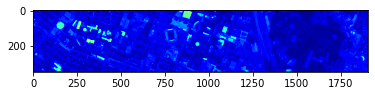

In [ ]:
import matplotlib.pyplot as plt
a=hysp1[:,:,50]
print(a.shape)
# plt.plot(hysp[:,:,1])
plt.imshow(a.T,cmap="jet")
plt.show()

In [ ]:
import pandas as pd

df =pd.read_csv("/content/drive/MyDrive/datasets/houston/trainingdata.txt",delimiter="\t")
df.rename(columns={"769":"x","7":"y","1":"category"},inplace=True)
left=pd.DataFrame({"x":"769","y":"7","category":"1"},index =[0])
df = pd.concat([left, df]).reset_index(drop = True)
print(df)

        x    y category
0     769    7        1
1     768    7        1
2     772    7        1
3     771    7        1
4     770    7        1
...   ...  ...      ...
2827  293  172       15
2828  293  173       15
2829  294  173       15
2830  292  173       15
2831  293  174       15

[2832 rows x 3 columns]


In [ ]:
df=df.to_numpy()
print(df)

[['769' '7' '1']
 [768 7 1]
 [772 7 1]
 ...
 [294 173 15]
 [292 173 15]
 [293 174 15]]


In [ ]:
df.shape

(2832, 3)

In [ ]:
y_label_tr=np.zeros(2832)

for i in range(2832):
  y_label_tr[i]=df[i][2]

In [ ]:
y_label_tr.shape

(2832,)

In [ ]:
ds2=rasterio.open("/content/2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.tif")
print(ds2.shape)

(349, 1905)


In [ ]:
x=ds2.read(1)
m=np.amax(x)
x=x/m
ll=np.swapaxes(x,0,1)
print(ll.shape)

(1905, 349)


In [ ]:
test_co = np.genfromtxt('/content/drive/MyDrive/datasets/houston/test.txt')
test_co.shape

(12197, 3)

In [ ]:
train_co = np.genfromtxt('/content/drive/MyDrive/datasets/houston/trainingdata.txt')
train_co.shape

(2832, 3)

In [ ]:
p=11
hs_tr=np.zeros((2832,p,p,144))
ld_tr=np.zeros((2832,p,p))
train_label=np.zeros(2832)
for i in range(2832):
  x=int(train_co[i][0])
  y=int(train_co[i][1])
  train_label[i]=int(train_co[i][2]-1)
  if y>=6 and y<=344 and x>=6 and x<=1898:
      hs_tr[i]=hysp1[ x-6:x+5 , y-6:y+5 ,:]
      ld_tr[i]=ll[ x-6:x+5 , y-6:y+5 ]
  
print(hs_tr.shape)

ld_tr=np.reshape(ld_tr,(2832,11,11,1))
print(ld_tr.shape)
print(train_label.shape)

(2832, 11, 11, 144)
(2832, 11, 11, 1)
(2832,)


In [ ]:
p=11
hs_tt=np.zeros((12197,p,p,144))
ld_tt=np.zeros((12197,p,p))
test_label=np.zeros(12197)
for i in range(12197):
  x=int(test_co[i][0])
  y=int(test_co[i][1])
  test_label[i]=int(test_co[i][2]-1)
  if y>=6 and y<=344 and x>=6 and x<=1898:
      hs_tt[i]=hysp1[ x-6:x+5 , y-6:y+5 ,:]
      ld_tt[i]=ll[ x-6:x+5 , y-6:y+5 ]
  
print(hs_tt.shape)

ld_tt=np.reshape(ld_tt,(12197,11,11,1))
print(ld_tt.shape)
print(test_label.shape)

(12197, 11, 11, 144)
(12197, 11, 11, 1)
(12197,)


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        # print("batch_size",batch_size)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        # print("patches shape",patches.shape)
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim      
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, hs_input, ld_input, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=hs_input, value=ld_input, key=hs_input
        )
        # print("attention_output",attention_output)
        proj_input = self.layernorm_1(hs_input + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [ ]:
image_size = 11
patch_size = 1 
num_patches = (image_size // patch_size) ** 2
projection_dim = 256
embed_dim = 256
dense_dim = 1024
num_heads = 8

hs_inp = keras.Input(shape=(image_size,image_size,144))
ld_inp = keras.Input(shape=(image_size,image_size,1))

hs_patches = Patches(patch_size=patch_size)(hs_inp)
ld_patches = Patches(patch_size=patch_size)(ld_inp)

hs_encoded_patches = PatchEncoder(num_patches, projection_dim)(hs_patches)
ld_encoded_patches = PatchEncoder(num_patches, projection_dim)(ld_patches)

encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)(hs_encoded_patches, ld_encoded_patches)
encoder_1 = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder, ld_encoded_patches)
encoder_2 = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder, hs_encoded_patches)
add = layers.Add()([encoder_1, encoder_2])

flatten = layers.Flatten()(add)
output = layers.Dense(15, activation="softmax")(flatten)
model = keras.Model((hs_inp,ld_inp), output)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 11, 11, 144  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 11, 11, 1)]  0           []                               
                                                                                                  
 patches_2 (Patches)            (None, None, 144)    0           ['input_3[0][0]']                
                                                                                                  
 patches_3 (Patches)            (None, None, 1)      0           ['input_4[0][0]']          

In [ ]:
print(hs_tr.shape)

(2832, 11, 11, 144)


In [ ]:
print(ld_tr.shape)

(2832, 11, 11, 1)


In [ ]:
print(train_label.shape)
print(max(train_label))
print(min(train_label))

(2832,)
14.0
0.0


In [ ]:
hs_tr90 = np.empty([2832,11,11,144], dtype = 'float32')
hs_tr180 = np.empty([2832,11,11,144], dtype = 'float32')
hs_tr270 = np.empty([2832,11,11,144], dtype = 'float32')

ld_tr90 = np.empty([2832,11,11,1], dtype = 'float32')
ld_tr180 = np.empty([2832,11,11,1], dtype = 'float32')
ld_tr270 = np.empty([2832,11,11,1], dtype = 'float32')

for i in tqdm.tqdm(range(2832)):
  hs_tr90[i,:,:,:] = np.rot90(hs_tr[i,:,:,:])
  hs_tr180[i,:,:,:] = np.rot90(hs_tr90[i,:,:,:])
  hs_tr270[i,:,:,:] = np.rot90(hs_tr180[i,:,:,:])

  ld_tr90[i,:,:,:] = np.rot90(ld_tr[i,:,:,:])
  ld_tr180[i,:,:,:] = np.rot90(ld_tr90[i,:,:,:])
  ld_tr270[i,:,:,:] = np.rot90(ld_tr180[i,:,:,:])  

hs_train_patches = np.concatenate([hs_tr, hs_tr90, hs_tr180, hs_tr270], axis = 0)
ld_train_patches = np.concatenate([ld_tr, ld_tr90, ld_tr180, ld_tr270], axis = 0)
train_labels = np.concatenate([train_label, train_label, train_label, train_label] , axis = 0)

100%|██████████| 2832/2832 [00:00<00:00, 8947.63it/s]


In [ ]:
print(hs_train_patches.shape)
print(ld_train_patches.shape)
print(train_labels.shape)

(11328, 11, 11, 144)
(11328, 11, 11, 1)
(11328,)


In [ ]:
categorical_train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=15, dtype="float32")

In [ ]:
categorical_test_labels = tf.keras.utils.to_categorical(test_label, num_classes=15, dtype="float32")

In [ ]:
print(categorical_train_labels.shape)

(11328, 15)


In [ ]:
print(categorical_test_labels.shape)

(12197, 15)


In [ ]:
model.compile(loss= 'categorical_crossentropy' , optimizer= tf.keras.optimizers.Adam(learning_rate=5e-6) , metrics=[ 'accuracy' ])

In [ ]:
epochaccuracy = []
highestaccuracy = [0]
trainacc = []

In [ ]:
temp_acc = highestaccuracy[-1]
ep = 0
predsf = np.zeros((12917, 15))
epochs = 1000
for i in range(epochs):
  gc.collect()
  history = model.fit((hs_train_patches, ld_train_patches), categorical_train_labels, batch_size = 32, epochs=1)
  trainacc.append(history.history["accuracy"])
  preds = model.predict((hs_tt, ld_tt))
  conf = confusion_matrix(test_label, np.argmax(preds,1)) 
  acc = np.trace(conf)/np.sum(conf)
  if acc>temp_acc:
    temp_acc = acc
    ep = i
    predsf = preds
  print('acc_max = ', np.round(100*temp_acc,2), '% at epoch', ep)
  highestaccuracy.append(temp_acc)
  print('epoch_acc = ', round(100*acc,2), '% at epoch', i)
  epochaccuracy.append(acc)

354/354 [==============================] - 24s 63ms/step - loss: 1.5450 - accuracy: 0.5439
acc_max =  61.75 % at epoch 0
epoch_acc =  61.75 % at epoch 0
354/354 [==============================] - 22s 62ms/step - loss: 0.7330 - accuracy: 0.7951
acc_max =  64.46 % at epoch 1
epoch_acc =  64.46 % at epoch 1
354/354 [==============================] - 22s 61ms/step - loss: 0.5079 - accuracy: 0.8445
acc_max =  65.92 % at epoch 2
epoch_acc =  65.92 % at epoch 2
354/354 [==============================] - 22s 62ms/step - loss: 0.3928 - accuracy: 0.8762
acc_max =  70.41 % at epoch 3
epoch_acc =  70.41 % at epoch 3
354/354 [==============================] - 22s 62ms/step - loss: 0.3101 - accuracy: 0.9022
acc_max =  71.46 % at epoch 4
epoch_acc =  71.46 % at epoch 4
354/354 [==============================] - 22s 63ms/step - loss: 0.2320 - accuracy: 0.9327
acc_max =  75.13 % at epoch 5
epoch_acc =  75.13 % at epoch 5
354/354 [==============================] - 22s 62ms/step - loss: 0.1795 - accuracy

KeyboardInterrupt: ignored

In [ ]:
preds = model.predict((hs_tt, ld_tt))

n_samples = 12189
correct = 0
for i in tqdm.tqdm(range(n_samples)):
  if np.argmax(preds[i]) == np.argmax(categorical_test_labels[i]):
      correct = correct + 1
accuracy = correct/n_samples

accuracy

100%|██████████| 12189/12189 [00:00<00:00, 261543.20it/s]


0.8017064566412339

## **START FROM HERE**

In [6]:
train_co = np.genfromtxt('/content/drive/MyDrive/datasets/houston/trainingdata.txt')
train_co.shape

(2832, 3)

In [7]:
test_co = np.genfromtxt('/content/drive/MyDrive/datasets/houston/test.txt')
test_co.shape

(12197, 3)

In [8]:
ds = rasterio.open('/content/2013_DFTC/2013_IEEE_GRSS_DF_Contest_CASI.tif')
ds.shape

(349, 1905)

In [9]:
import numpy as np
hysp=np.zeros((144,349,1905))
for i in range(144):
  x=ds.read(i+1)
  m=np.amax(x)
  x=x/m
  hysp[i]=x
print(hysp.shape)

(144, 349, 1905)


In [10]:
hysp1=np.swapaxes(hysp,2,0)
print(hysp1.shape)

(1905, 349, 144)


In [21]:
hs_train = []
train_label = []
for i in train_co:
  hs_train.append(hysp1[int(i[0]),int(i[1])])
  train_label.append(i[2]-1)
hs_train = np.asarray(hs_train)
train_label = np.asarray(train_label)

In [22]:
print(hs_train.shape)
hs_train = hs_train[:,:,np.newaxis]
print(hs_train.shape)
print(train_label.shape)

(2832, 144)
(2832, 144, 1)
(2832,)


In [23]:
hs_test = []
test_label = []
for i in test_co:
  hs_test.append(hysp1[int(i[0]),int(i[1])])
  test_label.append(i[2]-1)
hs_test = np.asarray(hs_test)
test_label = np.asarray(test_label)

In [24]:
print(hs_test.shape)
hs_test = hs_test[:,:,np.newaxis]
print(hs_test.shape)
print(test_label.shape)

(12197, 144)
(12197, 144, 1)
(12197,)


In [11]:
ds2=rasterio.open("/content/2013_DFTC/2013_IEEE_GRSS_DF_Contest_LiDAR.tif")
print(ds2.shape)

(349, 1905)


In [12]:
x=ds2.read(1)
m=np.amax(x)
x=x/m
ll=np.swapaxes(x,0,1)
print(ll.shape)

(1905, 349)


In [23]:
p=3
ld_train=np.zeros((2832,p,p))
for i in range(2832):
  x=int(train_co[i][0])
  y=int(train_co[i][1])
  if y>=2 and y<=348 and x>=2 and x<=1904:
      ld_train[i]=ll[ x-2:x+1 , y-2:y+1 ]
  
print(ld_train.shape)
ld_train=np.reshape(ld_train,(-1,3,3,1))
print(ld_train.shape)

(2832, 3, 3)
(2832, 3, 3, 1)


In [13]:
def create_patches_ld(patch_size, image, text_file_array):
  patches = np.zeros((text_file_array.shape[0], patch_size, patch_size))
  for i in range(text_file_array.shape[0]):
    x = int(text_file_array[i][0])
    y = int(text_file_array[i][1])
    if y>=(patch_size//2 +1) and y<=(image.shape[1] - patch_size//2) and x>=(patch_size//2 +1) and x<=(image.shape[0] - patch_size//2):
      patches[i] = image[ x - (patch_size//2 +1) : x + (patch_size//2) , y - (patch_size//2 +1) : y + (patch_size//2) ]
  
  return patches

In [14]:
def create_patches_hs(patch_size, image, text_file_array):
  patches = np.zeros((text_file_array.shape[0], patch_size, patch_size, image.shape[2]))
  for i in range(text_file_array.shape[0]):
    x = int(text_file_array[i][0])
    y = int(text_file_array[i][1])
    if y>=(patch_size//2 +1) and y<=(image.shape[1] - patch_size//2) and x>=(patch_size//2 +1) and x<=(image.shape[0] - patch_size//2):
      patches[i] = image[ x - (patch_size//2 +1) : x + (patch_size//2) , y - (patch_size//2 +1) : y + (patch_size//2) , :]
  
  return patches

In [25]:
patch_size=5
ld_train = create_patches_ld(patch_size, ll, train_co)
ld_train.shape

(2832, 5, 5)

In [26]:
patch_size=5
hs_train = create_patches_hs(patch_size, hysp1, train_co)
hs_train.shape

(2832, 5, 5, 144)

In [32]:
patch_size = 5

hs_tr90 = np.empty([2832,patch_size,patch_size,144], dtype = 'float32')
hs_tr180 = np.empty([2832,patch_size,patch_size,144], dtype = 'float32')
hs_tr270 = np.empty([2832,patch_size,patch_size,144], dtype = 'float32')

ld_tr90 = np.empty([2832,patch_size,patch_size,1], dtype = 'float32')
ld_tr180 = np.empty([2832,patch_size,patch_size,1], dtype = 'float32')
ld_tr270 = np.empty([2832,patch_size,patch_size,1], dtype = 'float32')

hs_train = create_patches_hs(patch_size, hysp1, train_co)

ld_train = create_patches_ld(patch_size, ll, train_co)
ld_train = np.reshape(ld_train , (-1,patch_size,patch_size,1))

for i in tqdm.tqdm(range(2832)):
  hs_tr90[i,:,:,:] = np.rot90(hs_train[i,:,:,:])
  hs_tr180[i,:,:,:] = np.rot90(hs_tr90[i,:,:,:])
  hs_tr270[i,:,:,:] = np.rot90(hs_tr180[i,:,:,:])

  ld_tr90[i,:,:,:] = np.rot90(ld_train[i,:,:,:])
  ld_tr180[i,:,:,:] = np.rot90(ld_tr90[i,:,:,:])
  ld_tr270[i,:,:,:] = np.rot90(ld_tr180[i,:,:,:])  

hs_train_patches = np.concatenate([hs_train, hs_tr90, hs_tr180, hs_tr270], axis = 0)
ld_train_patches = np.concatenate([ld_train, ld_tr90, ld_tr180, ld_tr270], axis = 0)
train_label_aug = np.concatenate([train_label, train_label, train_label, train_label] , axis = 0)

100%|██████████| 2832/2832 [00:00<00:00, 12784.84it/s]


In [33]:
print(hs_train_patches.shape)
print(ld_train_patches.shape)
print(train_label_aug.shape)
# ld_train_patches=np.reshape(ld_train_patches,(11328,9,1))
# print(ld_train_patches.shape)


(11328, 5, 5, 144)
(11328, 5, 5, 1)
(11328,)


In [34]:
patch_size=5
hs_test = create_patches_hs(patch_size, hysp1, test_co)
ld_test = create_patches_ld(patch_size, ll, test_co)
ld_test = np.reshape(ld_test , (-1,patch_size,patch_size,1))

print(hs_test.shape)
print(ld_test.shape)
print(test_label.shape)

(12197, 5, 5, 144)
(12197, 5, 5, 1)
(12197,)


In [43]:
# p=3
# ld_test=np.zeros((12197,p,p))
# for i in range(12197):
#   x=int(test_co[i][0])
#   y=int(test_co[i][1])
#   if y>=2 and y<=348 and x>=2 and x<=1904:
#       ld_test[i]=ll[ x-2:x+1 , y-2:y+1 ]
  
# print(ld_test.shape)
# ld_test=np.reshape(ld_test,(12197,9,1))
# print(ld_test.shape)

(12197, 3, 3)
(12197, 9, 1)


In [35]:
class PositionEncoder(layers.Layer):
    def __init__(self, modality_dim, projection_dim):
        super(PositionEncoder, self).__init__()
        self.modality_dim = modality_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=modality_dim, output_dim=projection_dim
        )

    def call(self, images):
        positions = tf.range(start=0, limit=self.modality_dim, delta=1)
        encoded = self.projection(images) + self.position_embedding(positions)
        return encoded

In [36]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim      
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, input, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=input, value=input, key=input
        )
        # print("attention_output",attention_output)
        proj_input = self.layernorm_1(input + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [29]:
projection_dim = 16
embed_dim = 16
dense_dim = 256
num_heads = 8

# hyp_dim = 144
# ld_dim = 9
patch_size = 5

# hs_inp = keras.Input(shape=(144,1))
# ld_inp = keras.Input(shape=(9,1))
hs_inp = keras.Input(shape=(patch_size,patch_size,144))
ld_inp = keras.Input(shape=(patch_size,patch_size,1))

hs_conv1 = layers.Conv2D(128,3,activation='relu',padding='same')(hs_inp)
hs_conv2 = layers.Conv2D(128,3,activation='relu',padding='same')(hs_conv1)
hs_conv3 = layers.Conv2D(128,3,activation='relu',padding='same')(hs_conv2)
hs_avgpool = layers.GlobalAveragePooling2D()(hs_conv3)

ld_conv1 = layers.Conv2D(128,3,activation='relu',padding='same')(ld_inp)
ld_conv2 = layers.Conv2D(128,3,activation='relu',padding='same')(ld_conv1)
ld_conv3 = layers.Conv2D(128,3,activation='relu',padding='same')(ld_conv2)
ld_avgpool = layers.GlobalAveragePooling2D()(ld_conv3)

# hs_encoded = PositionEncoder(hyp_dim, projection_dim)(hs_inp)
# ld_encoded = PositionEncoder(ld_dim, projection_dim)(ld_inp)
hs_encoded = PositionEncoder(128, projection_dim)(layers.Reshape((128,1))(hs_avgpool))
ld_encoded = PositionEncoder(128, projection_dim)(layers.Reshape((128,1))(ld_avgpool))

encoded = layers.Concatenate(axis=1)([hs_encoded,ld_encoded])

encoder1 = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoded)
encoder2 = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder1)
# encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder)

# flatten = layers.Flatten()(encoder2)
# mid = layers.Reshape((-1,1))(layers.Dense(144, activation="relu")(flatten))
output = layers.Dense(15, activation="softmax")(layers.Flatten()(encoder1))

# model = keras.Model((hs_inp,ld_inp), (output,mid))
model = keras.Model((hs_inp,ld_inp), output)

In [46]:
def mod_con(stack = 3, dim = 16, d_dim = 256 ):
  projection_dim = dim
  embed_dim = dim
  dense_dim = d_dim
  num_heads = 8

  # hyp_dim = 144
  # ld_dim = 9
  patch_size = 5

  # hs_inp = keras.Input(shape=(144,1))
  # ld_inp = keras.Input(shape=(9,1))
  hs_inp = keras.Input(shape=(patch_size,patch_size,144))
  ld_inp = keras.Input(shape=(patch_size,patch_size,1))

  hs_conv1 = layers.Conv2D(128,3,activation='relu',padding='same')(hs_inp)
  hs_conv2 = layers.Conv2D(128,3,activation='relu',padding='same')(hs_conv1)
  hs_conv3 = layers.Conv2D(128,3,activation='relu',padding='same')(hs_conv2)
  hs_avgpool = layers.GlobalAveragePooling2D()(hs_conv3)

  ld_conv1 = layers.Conv2D(128,3,activation='relu',padding='same')(ld_inp)
  ld_conv2 = layers.Conv2D(128,3,activation='relu',padding='same')(ld_conv1)
  ld_conv3 = layers.Conv2D(128,3,activation='relu',padding='same')(ld_conv2)
  ld_avgpool = layers.GlobalAveragePooling2D()(ld_conv3)

  # hs_encoded = PositionEncoder(hyp_dim, projection_dim)(hs_inp)
  # ld_encoded = PositionEncoder(ld_dim, projection_dim)(ld_inp)
  hs_encoded = PositionEncoder(128, projection_dim)(layers.Reshape((128,1))(hs_avgpool))
  ld_encoded = PositionEncoder(128, projection_dim)(layers.Reshape((128,1))(ld_avgpool))

  encoded = layers.Concatenate(axis=1)([hs_encoded,ld_encoded])

  for _ in range(stack):
    encoded = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoded)
  # encoder2 = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder1)
  # encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)(encoder)

  flatten = layers.Flatten()(encoded)
  # mid = layers.Dense(144, activation="relu")(flatten)
  output = layers.Dense(15, activation="softmax")(flatten)

  # model = keras.Model((hs_inp,ld_inp), (output,mid))
  return keras.Model((hs_inp,ld_inp), output)

In [47]:
m = []
for s in [2,4,8]:
  for d in [8,16,32]:
    for d_dim in [128]:
      m.append(mod_con(s,d,d_dim))

In [48]:
for model in m:
  model.compile(loss= ['categorical_crossentropy'] , optimizer= tf.keras.optimizers.Adam(learning_rate=5e-6) , metrics=[ 'accuracy' ])

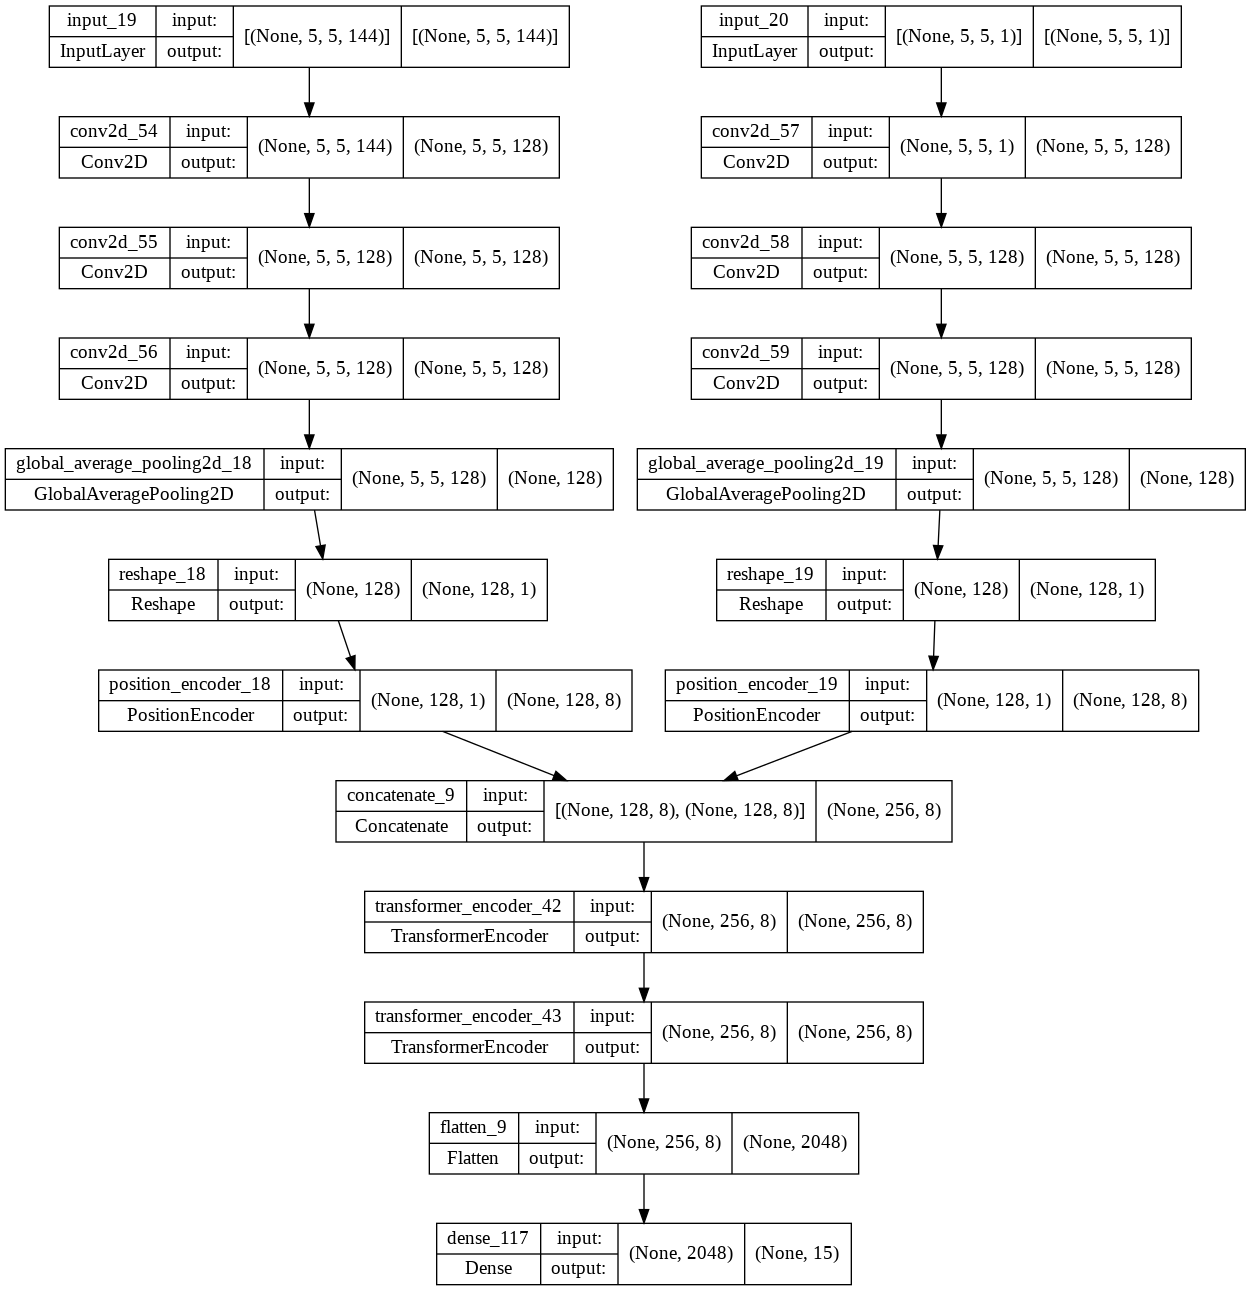

In [49]:
keras.utils.plot_model(m[0],show_shapes=True)

In [50]:
categorical_train_label = tf.keras.utils.to_categorical(train_label, num_classes=15, dtype="float32")
print(categorical_train_label.shape)

categorical_test_label = tf.keras.utils.to_categorical(test_label, num_classes=15, dtype="float32")
print(categorical_test_label.shape)

categorical_train_label_aug = tf.keras.utils.to_categorical(train_label_aug, num_classes=15, dtype="float32")
print(categorical_train_label_aug.shape)

(2832, 15)
(12197, 15)
(11328, 15)


In [51]:
# model.compile(loss= ['categorical_crossentropy','mse'] , optimizer= tf.keras.optimizers.Adam(learning_rate=5e-5) , metrics=[ 'accuracy' ])
# model.compile(loss= ['categorical_crossentropy','mse'] , optimizer= tf.keras.optimizers.Adam() , metrics=[ 'accuracy' ])
# model.compile(loss= ['categorical_crossentropy'] , optimizer= tf.keras.optimizers.Adam() , metrics=[ 'accuracy' ])
model.compile(loss= ['categorical_crossentropy'] , optimizer= tf.keras.optimizers.Adam(learning_rate=5e-6) , metrics=[ 'accuracy' ])

In [51]:
def mask(percent,hs1,ld1):
  hs=hs1.copy()
  ld=ld1.copy()

  mask_hs = np.ones((hs.shape))
  mask_ld = np.ones((ld.shape))

  mask_hs=np.reshape(mask_hs,(-1))
  id=np.arange(len(mask_hs))
  np.random.shuffle(id)
  id=id[:int(percent*len(id))]
  # print(len(id))
  mask_hs[id]=0
  mask_hs=np.reshape(mask_hs,hs.shape)

  mask_ld=np.reshape(mask_ld,(-1))
  id=np.arange(len(mask_ld))
  np.random.shuffle(id)
  id=id[:int(percent*len(id))]
  # print(len(id))
  mask_ld[id]=0
  mask_ld=np.reshape(mask_ld,ld.shape)

  hs=hs*mask_hs
  ld=ld*mask_ld

  return hs,ld

In [52]:
print(hs_train_patches.shape)
print(ld_train_patches.shape)
# ld_train_patches=np.reshape(ld_train_patches,(11328,9,1))
print(ld_train_patches.shape)
h,l = mask(0.75, hs_train_patches, ld_train_patches)
print(h.shape,l.shape)
print(categorical_train_label_aug.shape)

(11328, 5, 5, 144)
(11328, 5, 5, 1)
(11328, 5, 5, 1)
(11328, 5, 5, 144) (11328, 5, 5, 1)
(11328, 15)


(11328, 15)

In [57]:
epochaccuracy = []
highestaccuracy = [0 for _ in range(len(m))]
highestaccuracy_epoch = [0 for _ in range(len(m))]
trainacc = []

In [54]:
a = model.predict((hs_train_patches,ld_train_patches ))

In [55]:
np.amax(hs_train_patches)

0.6894453167915344

In [59]:
temp_acc = highestaccuracy[-1]
ep = 0
predsf = np.zeros((12917, 15))
epochs = 100
for i in range(epochs):
  gc.collect()
  id1 = np.arange(len(hs_train_patches))
  np.random.shuffle(id1)
  id1 = id1[:]
  hs1 = hs_train_patches[id1]
  ld1 = ld_train_patches[id1]
  h,l = mask(0.1, hs1, ld1)
  y = categorical_train_label_aug[id1]
  print("epoch number:",i)
  for model in m:
    # history = model.fit((h, l), (y,hs1), batch_size = 32, epochs=1)
    # preds = model.predict((hs_test, ld_test))[0]
    history = model.fit((h, l), y, batch_size = 32, epochs=1, verbose =0)
    preds = model.predict((hs_test, ld_test))
    conf = confusion_matrix(test_label, np.argmax(preds,1))
    acc = np.trace(conf)/np.sum(conf)

    if acc>highestaccuracy[m.index(model)]:
      highestaccuracy[m.index(model)] = acc
      highestaccuracy_epoch[m.index(model)] = i

    print('acc_max = ', np.round(100*highestaccuracy[m.index(model)],2), '% at epoch', highestaccuracy_epoch[m.index(model)], 'for model ', m.index(model) )
    print('epoch_acc = ', np.round(100*acc,2), '% at epoch', i ,'for model ', m.index(model) )
  print('\n')

epoch number: 0
acc_max =  26.3 % at epoch 0 for model  0
epoch_acc =  26.3 % at epoch 0 for model  0
acc_max =  26.41 % at epoch 0 for model  1
epoch_acc =  26.41 % at epoch 0 for model  1
acc_max =  20.55 % at epoch 0 for model  2
epoch_acc =  20.55 % at epoch 0 for model  2
acc_max =  22.28 % at epoch 0 for model  3
epoch_acc =  22.28 % at epoch 0 for model  3
acc_max =  40.77 % at epoch 0 for model  4
epoch_acc =  40.77 % at epoch 0 for model  4
acc_max =  26.0 % at epoch 0 for model  5
epoch_acc =  26.0 % at epoch 0 for model  5
acc_max =  31.88 % at epoch 0 for model  6
epoch_acc =  31.88 % at epoch 0 for model  6
acc_max =  39.69 % at epoch 0 for model  7
epoch_acc =  39.69 % at epoch 0 for model  7
acc_max =  24.08 % at epoch 0 for model  8
epoch_acc =  24.08 % at epoch 0 for model  8


epoch number: 1
acc_max =  48.71 % at epoch 1 for model  0
epoch_acc =  48.71 % at epoch 1 for model  0
acc_max =  44.6 % at epoch 1 for model  1
epoch_acc =  44.6 % at epoch 1 for model  1
acc_

In [60]:
j = 0
for model in m:
  model.save("/content/drive/MyDrive/datasets/fusionmodels/100/"+str(j)+".h5")
  j=j+1

NotImplementedError: ignored

In [62]:
import pickle
with open("/content/drive/MyDrive/datasets/fusionmodels/100/highestaccuracy.pkl", "wb") as fp:
  pickle.dump(highestaccuracy, fp)

with open("/content/drive/MyDrive/datasets/fusionmodels/100/highestaccuracy_epoch.pkl", "wb") as fp:
  pickle.dump(highestaccuracy_epoch, fp)

In [ ]:
temp_acc

0.2972862179224399

In [69]:
import pickle

In [70]:
# with open("/content/drive/MyDrive/datasets/epochaccuracy.pkl", "wb") as fp:
#   pickle.dump(epochaccuracy, fp)

with open("/content/drive/MyDrive/datasets/highestaccuracy.pkl", "wb") as fp:
  pickle.dump(highestaccuracy, fp)


highestaccuracy_epoch
# with open("/content/drive/MyDrive/datasets/trainacc.pkl", "wb") as fp:
#   pickle.dump(trainacc, fp)

In [71]:
preds = model.predict((hs_test, ld_test))

n_samples = 12189
correct = 0
for i in tqdm.tqdm(range(n_samples)):
  if np.argmax(preds[i]) == np.argmax(categorical_test_label[i]):
      correct = correct + 1
accuracy = correct/n_samples

accuracy

100%|██████████| 12189/12189 [00:00<00:00, 247278.67it/s]


0.7537123636065305

In [ ]:
hysp1 = np.zeros((1905,349,144))
ll = np.zeros((1905,349))
l = np.zeros((1909,353))

l[2:2+1905 , 2:2+349] = ll


In [ ]:
class_map = np.zeros((1905,349))

In [ ]:
for i in range(1905):
  d = hysp1[i,:,:]
  l_p = []
  for j in range(349):
    i_hat = i+2
    j_hat = j+2
    l_p.append(l[i_hat-2:i_hat-2+5,j_hat-2:j_hat-2+5])

  l_p = np.asarray(l_p)

  preds = m[8].predict((d,l_p),batch_size=32)
  preds = np.argmax(preds,axis=-1)

  class_map[i,:] = preds[:]

KeyboardInterrupt: ignored

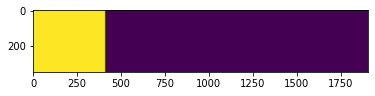

In [ ]:
plt.imshow(class_map.T)

In [ ]:
np.unique(class_map)

array([0., 5.])